In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [10]:
# Data Loading
# Load Data (Cleaned by Stream 2) & Load Market Data (Stream 4 / New 2025 Specs)
df_usage = pd.read_csv('clean_ev_data.csv')
df_market = pd.read_csv('electric_vehicles_spec_2025.csv')

print(f"Usage Data Loaded: {len(df_usage)} rows")
print(f"Market Data Loaded: {len(df_market)} rows")

sns.set_theme(style="whitegrid")

Usage Data Loaded: 1320 rows
Market Data Loaded: 478 rows


In [11]:
# Data Engineering

# Estimate price based on segment (since 2025 data lacks price)
def estimate_price(segment):
    if pd.isna(segment): return 45000
    if 'A -' in segment or 'B -' in segment: return 30000  # Economy
    if 'C -' in segment or 'D -' in segment: return 48000  # Mid-Range
    if 'E -' in segment or 'F -' in segment: return 85000  # Premium
    if 'S -' in segment: return 75000 # Sports
    return 55000 

df_market['Estimated_Price'] = df_market['segment'].apply(estimate_price)

# Simplify segments
def simplify_segment(segment):
    if pd.isna(segment): return 'Mid-Range'
    if 'A -' in segment or 'B -' in segment: return 'Economy'
    if 'E -' in segment or 'F -' in segment or 'S -' in segment: return 'Premium'
    return 'Mid-Range'

df_market['Category'] = df_market['segment'].apply(simplify_segment)

# Standardise Car Body Type 
def simplify_body(body):
    if pd.isna(body): return 'Other'
    if 'SUV' in body: return 'SUV'
    if 'Sedan' in body: return 'Sedan'
    if 'Hatchback' in body: return 'Hatchback'
    return 'Other'

df_market['Body_Type'] = df_market['car_body_type'].apply(simplify_body)

/var/folders/rg/vyscxbdx2ss1xd5k_5hgxfwc0000gn/T/ipykernel_60310/236435345.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=main_types, x='Body_Type', y='Efficiency_km_kWh', palette='Set2')


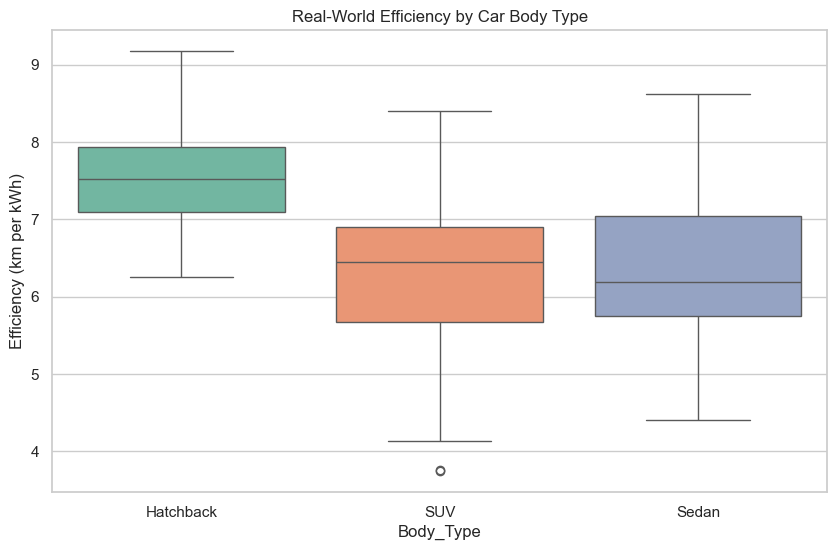

In [12]:
# Convert efficiency (Wh/km -> km/kWh)
df_market['Efficiency_km_kWh'] = 1000 / df_market['efficiency_wh_per_km']

# Visuals for dashboard

# VISUAL 1: COST PER CATEGORY / EFFICIENCY BY CAR TYPE (Body Style)
# Purpose: Show the customer the price gap between Economy and Premium.
plt.figure(figsize=(10, 6))
# Filter to main types
main_types = df_market[df_market['Body_Type'].isin(['SUV', 'Sedan', 'Hatchback'])]
sns.boxplot(data=main_types, x='Body_Type', y='Efficiency_km_kWh', palette='Set2')
plt.title("Real-World Efficiency by Car Body Type")
plt.ylabel("Efficiency (km per kWh)")
plt.show()

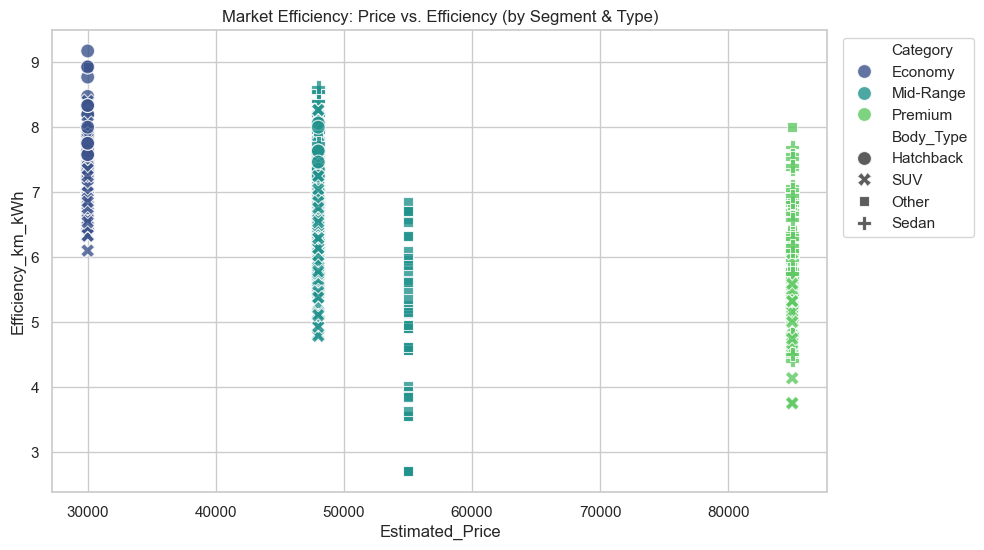

In [13]:
# VISUAL 2: EFFICIENCY VS PRICE
# Purpose: Answer "Do I get better range if I pay more?" (Miro Requirement)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_market, 
    x='Estimated_Price', 
    y='Efficiency_km_kWh', 
    hue='Category', 
    style='Body_Type',
    palette='viridis',
    s=100,
    alpha=0.8
)
plt.title("Market Efficiency: Price vs. Efficiency (by Segment & Type)")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

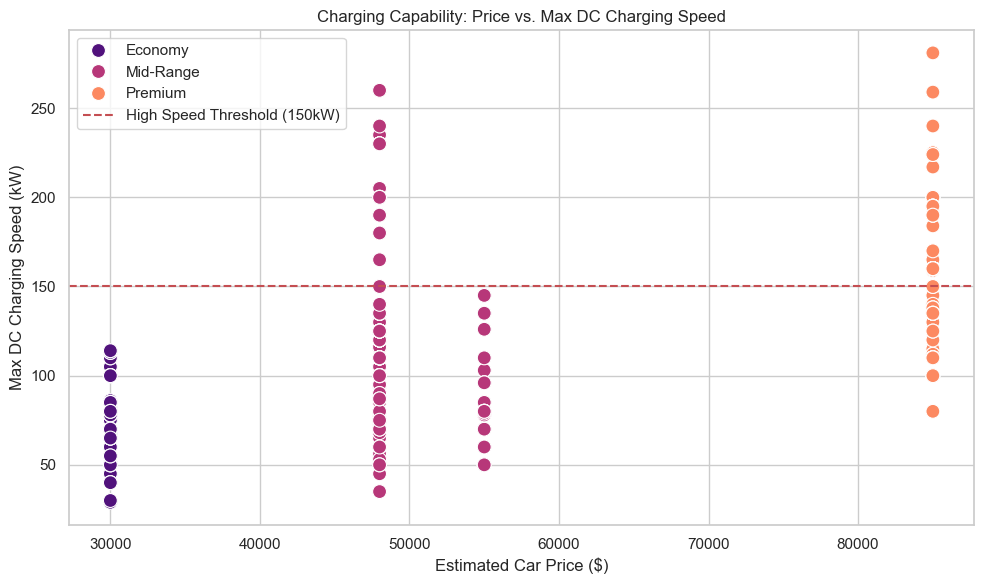

In [14]:
# VISUAL 3: CHARGING SPEED & PRICE (AC vs DC Inputs)
# Purpose: Miro - "explore price differential between AC and DC inputs".
# Since most 2025 cars have DC, analyse "Fast Charging Speed" vs "Price".
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_market,
    x='Estimated_Price',
    y='fast_charging_power_kw_dc',
    hue='Category',
    palette='magma',
    s=100
)
plt.title("Charging Capability: Price vs. Max DC Charging Speed")
plt.xlabel("Estimated Car Price ($)")
plt.ylabel("Max DC Charging Speed (kW)")
plt.axhline(y=150, color='r', linestyle='--', label="High Speed Threshold (150kW)")
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
# PREDICTOR: CHEAPEST MILE PER CITY
# Purpose: The "Customer Tool" to predict costs for actual users.

# Step 1: Get electricity costs
city_costs = df_usage.groupby('Charging Station Location')['Price per kWh'].mean().reset_index()

# Step 2: The Hybrid Lookup ("Manual" Cars for accuracy)
comparison_cars = [
    {'Model': 'Nissan Leaf',  'Eff_km_kWh': 5.5, 'Type': 'Hatchback'}, 
    {'Model': 'Tesla Model 3','Eff_km_kWh': 6.5, 'Type': 'Sedan'}, 
    {'Model': 'BMW i3',       'Eff_km_kWh': 6.0, 'Type': 'Hatchback'}, 
    {'Model': 'Hyundai Kona', 'Eff_km_kWh': 5.8, 'Type': 'SUV'},       
    {'Model': 'Hummer EV',    'Eff_km_kWh': 2.5, 'Type': 'SUV'} 
]
df_compare = pd.DataFrame(comparison_cars)

# Step 3: Merge
df_pred = pd.merge(city_costs.assign(key=1), df_compare.assign(key=1), on='key').drop('key', axis=1)

# Step 4: Calculate
df_pred['Cost_Per_Km'] = df_pred['Price per kWh'] / df_pred['Eff_km_kWh']

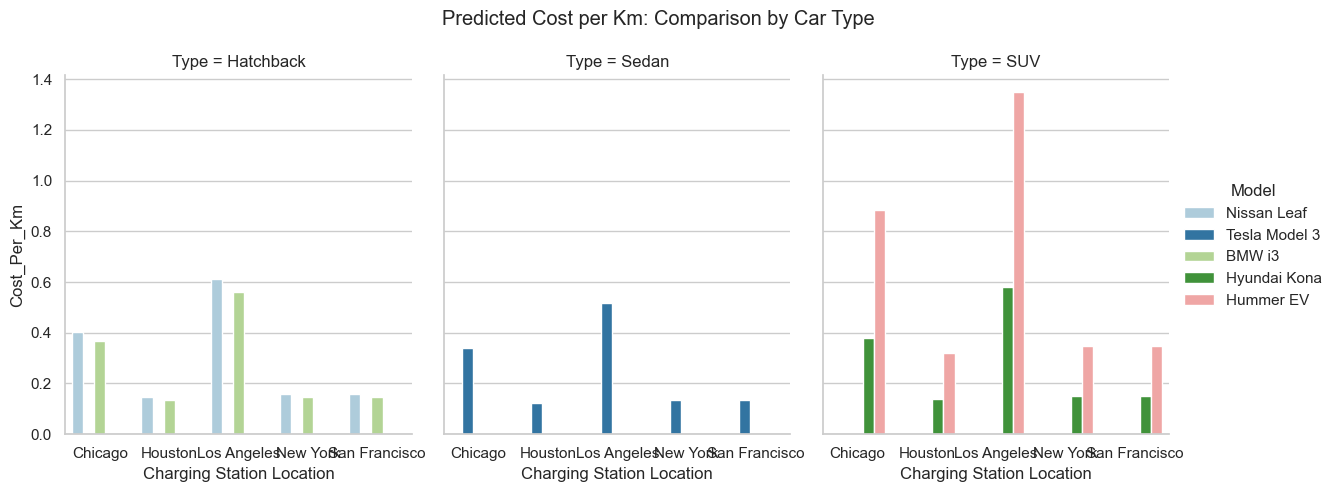

EDA Complete. All 4 Dashboard Visuals Generated.


In [16]:
# VISUAL 4: THE PREIDICTION CHART
g = sns.catplot(
    data=df_pred, 
    kind="bar",
    x="Charging Station Location", 
    y="Cost_Per_Km", 
    hue="Model",
    col="Type", # <--- This splits the chart into 3 columns
    palette="Paired",
    height=5, 
    aspect=0.8
)
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Predicted Cost per Km: Comparison by Car Type")
plt.show()

print("EDA Complete. All 4 Dashboard Visuals Generated.")